# Binance API Algorithm

In [3]:
# see Binance API: https://bit.ly/48jkoCf & https://bit.ly/49dBqmw

import websocket
import json
import pandas as pd
from binance.client import Client

In [4]:
client = Client(tld="us")

info = client.get_exchange_info()

# extract all symbol values (n["symbol"]) by looping through exchange info (info["symbols"])
pairs = [n["symbol"] for n in info["symbols"] if n["symbol"].endswith("USDT")]

pairs = [n.lower() + "@kline_5m" for n in pairs]

list_pairs = "/".join(pairs)

In [5]:
# Function 2: Convert client streams to dataframe

def manipulate (data):
    value = data["data"]["k"]
    price = value["c"]
    sym = value["s"]
    event_time = pd.to_datetime([data["data"]["E"]], unit="ms")
    df = pd.DataFrame([[price, sym]], index=event_time)
    return df

In [6]:
# Function 1: Websocket client

def on_message (wsapp, message):
    json_message = json.loads(message)
    dataframe = manipulate(json_message)
    dataframe.to_csv("Pair-Prices.csv", mode="a", header=False)

socket = "wss://stream.binance.us:9443/stream?streams=" + list_pairs

wsapp = websocket.WebSocketApp(socket, on_message=on_message)

wsapp.run_forever()

True

In [7]:
df = pd.read_csv("Pair-Prices.csv", header=None)

df.columns = ["Timestamp", "Price", "Pair"]

In [8]:
# access single column
btc_usdt = df[df.Pair == "BTCUSDT"]

# sort values by column
btc_usdt = btc_usdt.sort_values("Timestamp")

# set index to column values
btc_usdt = btc_usdt.set_index("Timestamp")

In [9]:
btc_usdt

,Price,Pair
Timestamp,,
2024-01-15 05:00:33.983,42500.68,BTCUSDT
2024-01-15 05:00:41.308,42500.68,BTCUSDT
2024-01-15 05:00:46.953,42500.68,BTCUSDT
2024-01-15 05:22:36.076,42592.88,BTCUSDT
2024-01-15 05:22:45.601,42568.24,BTCUSDT
...,...,...
2024-02-08 17:54:30.176,45162.28,BTCUSDT
2024-02-09 05:51:00.001,46203.69,BTCUSDT
2024-02-09 05:51:02.269,46203.69,BTCUSDT


<AxesSubplot:xlabel='Timestamp'>

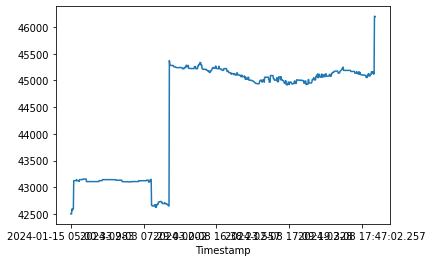

In [251]:
btc_usdt.set_index("Timestamp").Price.plot()

In [252]:
# Function #3 - access price changes of each Pair
def analyze(Pair):
    frame = df[df.Pair == Pair]
    frame = frame.sort_values("Timestamp")
    frame = frame.set_index("Timestamp")
    
    # Formula for Rate of Return
    frame = frame.Price[-1] / frame.Price[0] - 1 # divide last and first indexed "Price" value
    #return "{:.2%}".format(frame)
    return frame * 100

In [253]:
analyze("BTCUSDT")

8.694966762884725

In [254]:
# access all data from "Pairs" column, placed in array format
uq = df.Pair.unique()

returns = []

df = pd.read_csv("Pair-Prices.csv", header=None)
df.columns = ["Timestamp", "Price", "Pair"]

for Pair in uq:
    returns.append(analyze(Pair))

In [255]:
#returns

In [256]:
#pd.Series creates a column-like structure, using "index" values name for each row
series = pd.Series(returns, index = uq)

In [257]:
series

EGLDUSDT      -0.664820
BTCUSDT        8.694967
LINKUSDT      17.574353
VTHOUSDT     168.908297
AVAXUSDT      -0.690417
                ...    
CUDOSUSDT     18.339921
ADXUSDT        4.674556
FORTUSDT      -1.421405
SUIUSDT       13.241746
ONGUSDT        3.626772
Length: 157, dtype: float64

In [258]:
series.nsmallest(5)

1INCHUSDT   -11.264657
GALAUSDT    -11.226054
BTRSTUSDT   -10.958904
API3USDT    -10.398360
RLCUSDT      -8.243579
dtype: float64